# NDA_COURSEWORK Part 2

In [58]:
# importing the necessary libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import box
import random
import spaghetti as sp
import esda


## Task A: Spatial Networks and Planarity

### Loading and Preparing Accident Data (2010–2019)

To begin our analysis, we load and combine traffic accident datasets for the years 2010 to 2019. After loading, we drop any rows without coordinate information and convert the data into a GeoDataFrame, reprojecting it from the British National Grid (EPSG:27700) to WGS84 (EPSG:4326) for spatial analysis and mapping.

In [45]:
# Function to load and combine accident data from multiple years
def load_accident_data(data_dir, years):
    data_frames = []
    for year in years:
        # Handling different filenames
        if year == 2016:
            filename = "Copy%20of%20Leeds_RTC_2016.csv"
        elif year == 2017:
            filename = "Leeds_RTC_2017.csv"
        elif year == 2018:
            filename = "RTC%202018_Leeds.csv"
        elif year == 2019:
            filename = "Traffic%20accidents_2019_Leeds.csv"
        else:
            filename = f"{year}.csv"
        
        file_path = "{}/{}".format(data_dir,filename)
        df = pd.read_csv(file_path, encoding="ISO-8859-1")
        data_frames.append(df)

    # Combining all datasets
    df_all = pd.concat(data_frames, ignore_index=True)

    # Dropping rows with missing coordinates
    df_all = df_all.dropna(subset=["Grid Ref: Easting", "Grid Ref: Northing"])

    # Converting to GeoDataFrame (from British National Grid to WGS84)
    gdf = gpd.GeoDataFrame(
        df_all,
        geometry=gpd.points_from_xy(df_all["Grid Ref: Easting"], df_all["Grid Ref: Northing"]),
        crs="EPSG:27700"
    ).to_crs(epsg=4326)

    return gdf

### Preview Accident Data

Accident data from 2010–2019 is loaded and combined into a single GeoDataFrame. We preview the first few rows to verify the structure.

In [46]:
# Loading accident data from 2010 to 2019
years = list(range(2010, 2020))
data_directory = "../data/part2"
accidents_gdf = load_accident_data(data_directory, years)

# Printing the head of accidents dataframe
accidents_gdf.head()

,Reference Number,Easting,Northing,Number of Vehicles,Accident Date,Time (24hr),1st Road Class,Road Surface,Lighting Conditions,Weather Conditions,...,Unnamed: 15,Expr1,1st Road Class & No,Accident Fields_Reference Number,Local Authority,Vehicle Fields_Reference Number,Vehicle Number,Casualty Fields_Reference Number,Casualty Veh No,geometry
8199,130021591,NaN,NaN,3,15-Jan-13,1545,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.59184 53.79652)
8200,130021629,NaN,NaN,2,15-Jan-13,1640,A,Frost / Ice,Darkness: street lights present and lit,Other,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.63062 53.90457)
8201,130021704,NaN,NaN,2,13-Jan-13,1345,Unclassified,Wet / Damp,Daylight: street lights present,Fine without high winds,...,Motorcycle over 125cc and up to 500cc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.62965 53.8164)
8202,130022047,NaN,NaN,1,15-Jan-13,1313,Unclassified,Dry,Daylight: street lights present,Fine without high winds,...,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.54183 53.78723)
8203,130023385,NaN,NaN,1,16-Jan-13,2015,Unclassified,Dry,Darkness: street lights present and lit,Fine without high winds,...,Bus or coach (17 or more passenger seats),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-1.54036 53.79679)


### Selecting 1 km² Area in Central Leeds

We manually define a 1 km² bounding box around central Leeds using approximate coordinates from Google Maps. We then count how many accidents fall within this area to ensure it meets the requirement of at least 300 incidents.

In [47]:

# Defining manual central coordinates in Leeds (Picking coordinates from google maps near to center of leads)
center_lat, center_lon = 53.798928, -1.536309  

# Defining a ~1 km² box around the center (0.0045° ≈ 0.5 km)
buffer = 0.0045
north, south = center_lat + buffer, center_lat - buffer
east, west = center_lon + buffer, center_lon - buffer
selected_box = box(west, south, east, north)

# Counting accidents within the selected box
accidents_in_box = accidents_gdf[accidents_gdf.geometry.within(selected_box)]
print("Number of accidents in 1 km² around selected point:", len(accidents_in_box))


Number of accidents in 1 km² around selected point: 425


### Visualising Accidents in Selected Area

We plot all accidents across Leeds in light gray and highlight those within the selected 1 km² central area in red with a cyan boundary.

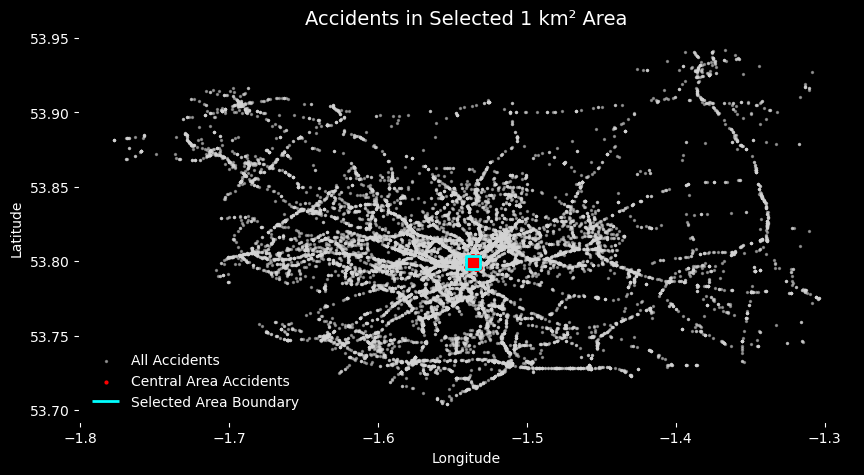

In [48]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor='black')  # large fig, dark mode

# Plot all accidents in light gray
accidents_gdf.plot(
    ax=ax,
    color='lightgray',
    alpha=0.5,
    markersize=2,
    label='All Accidents'
)

# Highlight accidents inside the selected 1 km² box in red
accidents_gdf[accidents_gdf.within(selected_box)].plot(
    ax=ax,
    color='red',
    markersize=4,
    label='Central Area Accidents'
)

# Draw the boundary of the selected 1 km² cell in cyan
gpd.GeoSeries([selected_box]).boundary.plot(
    ax=ax,
    color='cyan',
    linewidth=2,
    label='Selected Area Boundary'
)

# Set title and labels with white text
plt.title("Accidents in Selected 1 km² Area", fontsize=14, color='white')
plt.xlabel("Longitude", color='white')
plt.ylabel("Latitude", color='white')

# Customize ticks and axes for black background
ax.tick_params(colors='white')
ax.set_facecolor('black')

# Add legend
ax.legend(frameon=False, labelcolor='white', fontsize=10)

plt.show()

### Extracting and Plotting Selected Road Network (~1 km²)

We use `osmnx.graph_from_point()` to extract the drivable road network within ~500m of the selected center point, forming approximately a 1 km² area.

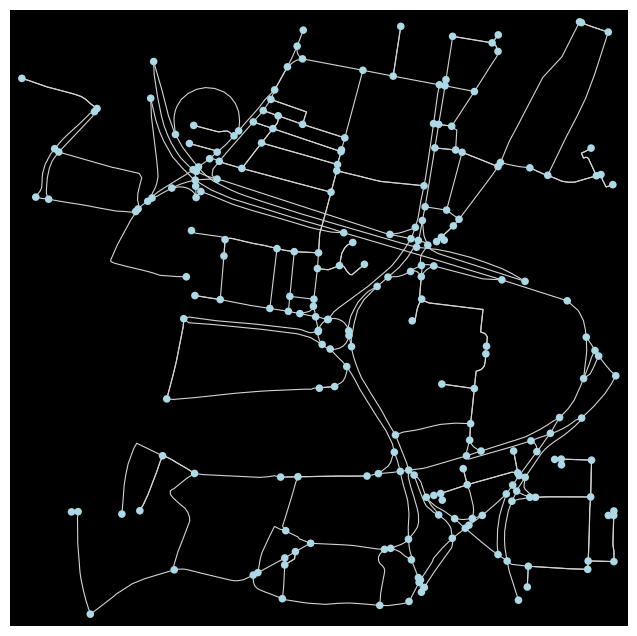

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [49]:
# Use graph_from_point to extract ~1 km² network
road_graph = ox.graph.graph_from_point(center_point=(center_lat, center_lon), dist=500, network_type='drive')

# Project to UTM for accurate spatial analysis. 
road_graph_proj = ox.projection.project_graph(road_graph)

# Plotting the road network with custom styling
ox.plot.plot_graph(
    road_graph_proj,
    bgcolor='black',            # Dark background
    node_size=30,               # Size of intersection points
    node_color="lightblue",     # Color of the nodes
    edge_linewidth=0.8,         # Thickness of road segments
    edge_color="lightgray"      # Color of road segments
)

### Computing Road Network Metrics

We define a function to calculate key statistics for the projected road network. These include:
- Average street length
- Node, edge, and intersection density
- Network diameter (based on the largest connected component)
- Circuitry (edge length relative to distance from centroid)
- Number of connected components
- Planarity and a counterexample if the network is non-planar

This function returns a dictionary of metrics.

In [50]:
def compute_network_stats(G_proj, area_m2=1_000_000):
    stats = ox.basic_stats(G_proj, area=area_m2)

    # Counting connected components
    n_components = nx.number_connected_components(G_proj.to_undirected())

    # Largest connected component for diameter
    largest_cc = max(nx.connected_components(G_proj.to_undirected()), key=len)
    subgraph = G_proj.subgraph(largest_cc)
    diameter = nx.diameter(subgraph.to_undirected())

    # Circuitry calculation
    total_edge_len = stats["edge_length_total"]
    nodes_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=False)
    centroid = nodes_proj.unary_union.centroid
    euclid_dists = [centroid.distance(pt) for pt in nodes_proj.geometry]
    euclid_sum = np.sum(euclid_dists)
    circuitry = total_edge_len / euclid_sum if euclid_sum > 0 else None

    # Planarity check
    is_planar, counterexample = nx.check_planarity(G_proj.to_undirected(), counterexample=True)

    return {
        "avg_street_length": stats["street_length_avg"],
        "node_density": stats["node_density_km"],
        "edge_density": stats["edge_density_km"],
        "intersection_density": stats["intersection_density_km"],
        "diameter": diameter,
        "circuitry": circuitry,
        "is_planar": is_planar,
        "planarity_counterexample": counterexample,
        "connected_components": n_components
    }

# Computing metrics for road network
network_metrics = compute_network_stats(road_graph_proj)

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/2826799979.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = nodes_proj.unary_union.centroid


### Printing and Visualise Road Network Metrics

This function prints the computed road network metrics.


Road Network Metrics:
Num of Connected Components: 1
Spatial Diameter: 27
Average Street Length: 62.201 meters
Node Density: 231.000 nodes/km²
Edge Density: 23890.382 edges/km²
Intersection Density: 204.000 intersections/km²
Average Circuitry: 0.304
Is the Network Planar?: No

Following is a counterexample causing non-planarity:


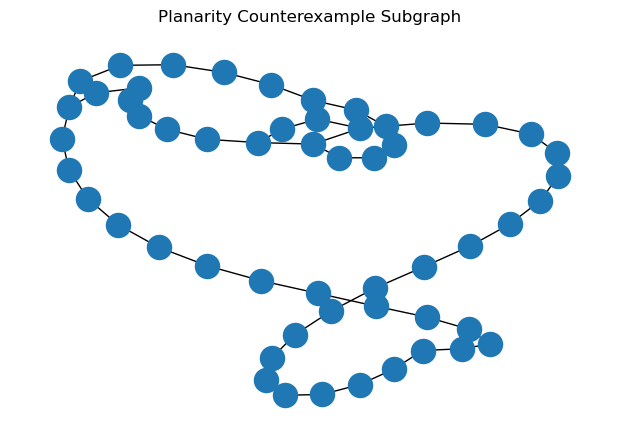

In [51]:
def print_network_metrics(metrics):
    print("\nRoad Network Metrics:")
    print(f"Num of Connected Components: {metrics['connected_components']}")
    print(f"Spatial Diameter: {metrics['diameter']}")
    print(f"Average Street Length: {metrics['avg_street_length']:.3f} meters")
    print(f"Node Density: {metrics['node_density']:.3f} nodes/km²")
    print(f"Edge Density: {metrics['edge_density']:.3f} edges/km²")
    print(f"Intersection Density: {metrics['intersection_density']:.3f} intersections/km²")
    print(f"Average Circuitry: {metrics['circuitry']:.3f}")
    
    if metrics["is_planar"]:
        print("Is the Network Planar?: Yes")
    else:
        print("Is the Network Planar?: No")
        print("\nFollowing is a counterexample causing non-planarity:")
        plt.figure(figsize=(6, 4))
        nx.draw(metrics["planarity_counterexample"])
        plt.title("Planarity Counterexample Subgraph")
        plt.show()


# Displaying the metrics
print_network_metrics(network_metrics)

# Task B: Road Accidents

### Prepare Network and Snap Accident Data

We convert the projected road network edges into a format compatible with the Spaghetti library and create a spatial network. Accident points are reprojected to match the network CRS and then snapped onto the network to enable spatial analysis.

In [ ]:
# Converting the projected edges to spaghetti-compatible format
edges_proj = ox.graph_to_gdfs(road_graph_proj, nodes=False)

# Creating the network from edges
network = sp.Network(in_data=edges_proj)

accidents_in_box_proj = accidents_in_box.to_crs(road_graph_proj.graph['crs'])

# Snapping reprojected accident points to the network
network.snapobservations(accidents_in_box_proj, 'accidents')

/opt/anaconda3/lib/python3.12/site-packages/spaghetti/network.py:3412: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/opt/anaconda3/lib/python3.12/site-packages/spaghetti/util.py:572: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/opt/anaconda3/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


### Plot Original Accident Locations

We visualise the original accident points (before snapping) over the road network.

Observation 1:
True coords:    (596140.8692548554, 5961901.214843292)
Snapped coords: (596139.085927884, 5961901.955916537)


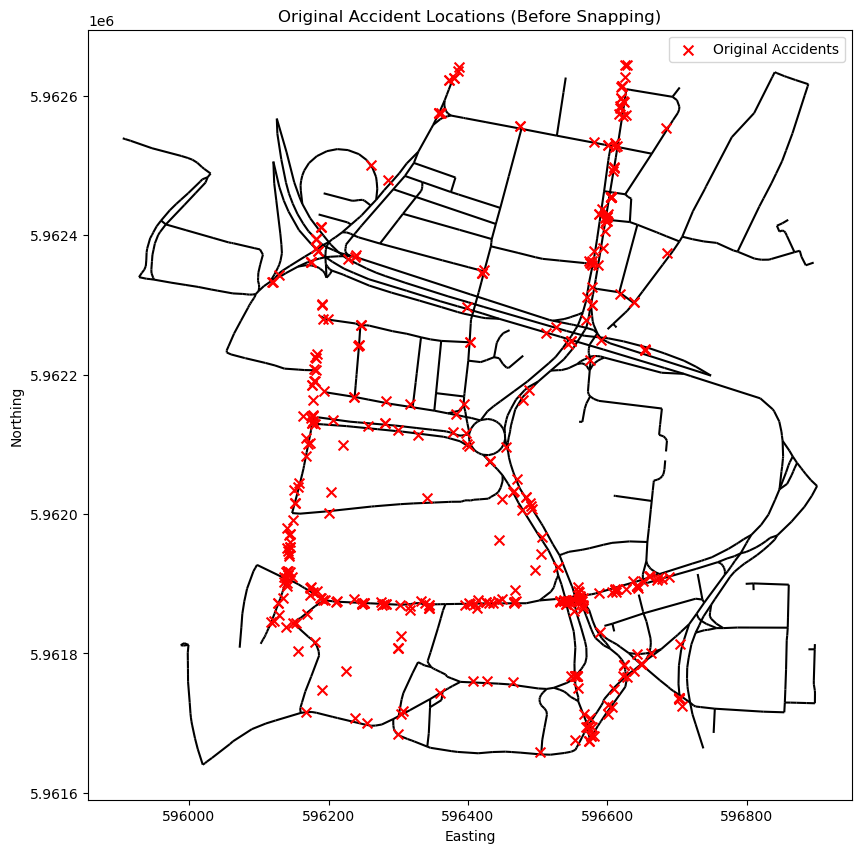

In [ ]:
# Getting node and edge GeoDataFrames from spaghetti
nodes_df, edges_df = sp.element_as_gdf(network, vertices=True, arcs=True)

# Plotting original (unsnapped) accidents
fig, ax = plt.subplots(figsize=(10, 10))
edges_df.plot(ax=ax, color="black", zorder=0)
sp.element_as_gdf(network, pp_name="accidents", snapped=False).plot(
    ax=ax, color="red", marker="x", markersize=50, zorder=1, label='Original Accidents'
)
plt.title("Original Accident Locations (Before Snapping)")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
plt.show()

### Plot Snapped Accidents on Network

We compare the original and snapped coordinates for accuracy, and then visualise all snapped accident points on the road network.

Observation 1:
True coords:    (596140.8692548554, 5961901.214843292)
Snapped coords: (596139.085927884, 5961901.955916537)


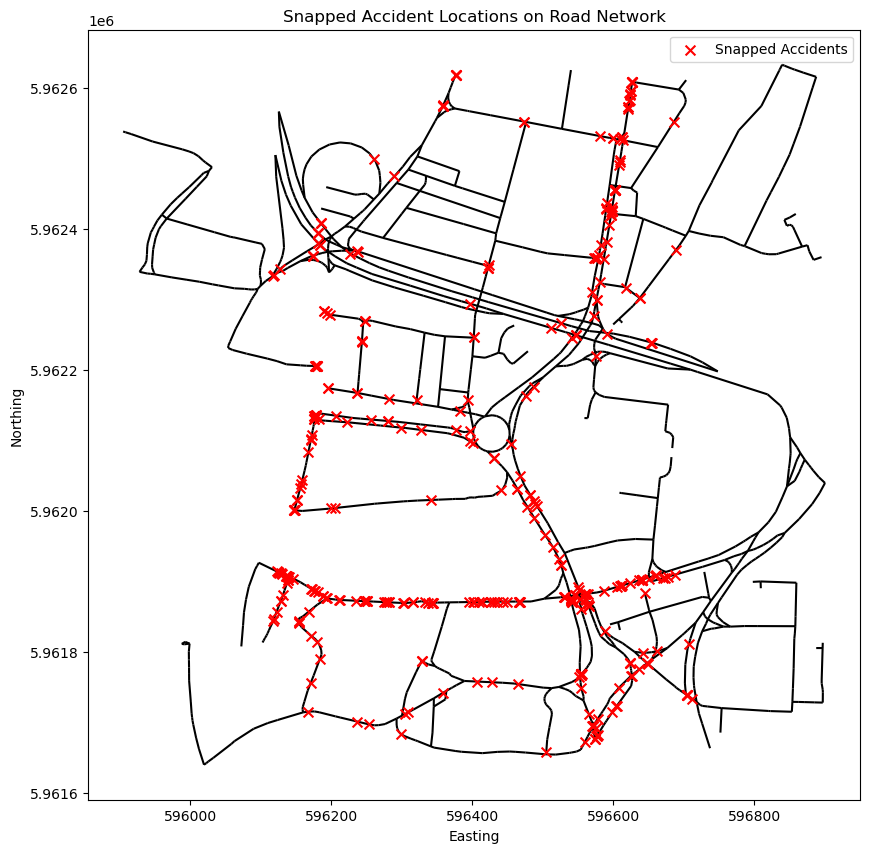

Number of accidents snapped to the network: 425


In [ ]:
# Printing coordinate comparison of first point
print("Observation 1:")
print("True coords:   ", network.pointpatterns["accidents"].points[0]["coordinates"])
print("Snapped coords:", network.pointpatterns["accidents"].snapped_coordinates[0])

# Plotting snapped accidents
fig, ax = plt.subplots(figsize=(10, 10))
edges_df.plot(ax=ax, color="black", zorder=0)
sp.element_as_gdf(network, pp_name="accidents", snapped=True).plot(
    ax=ax, color="red", marker="x", markersize=50, zorder=1, label='Snapped Accidents'
)
plt.title("Snapped Accident Locations on Road Network")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend()
plt.show()

# Count snapped points
num_snapped = len(network.pointpatterns["accidents"].points)
print("Number of accidents snapped to the network:", num_snapped)

### Analyze Accident Clustering with GlobalAutoK

We use `GlobalAutoK` to assess whether accidents are spatially clustered on the network. The observed K-function is compared against confidence envelopes generated through 100 random permutations. A higher observed K(r) value (above the upper envelope) indicates significant clustering at those distances. This helps us understand the scale and intensity of accident hotspots.

Density of points in the network (lambda): 0.02164909226029543
Distances at which density is measured:
[   0.           33.68730345   67.37460689  101.06191034  134.74921379
  168.43651723  202.12382068  235.81112412  269.49842757  303.18573102
  336.87303446  370.56033791  404.24764136  437.9349448   471.62224825
  505.3095517   538.99685514  572.68415859  606.37146203  640.05876548
  673.74606893  707.43337237  741.12067582  774.80797927  808.49528271
  842.18258616  875.86988961  909.55719305  943.2444965   976.93179994
 1010.61910339 1044.30640684 1077.99371028 1111.68101373 1145.36831718
 1179.05562062 1212.74292407 1246.43022752 1280.11753096 1313.80483441
 1347.49213786 1381.1794413  1414.86674475 1448.55404819 1482.24135164
 1515.92865509 1549.61595853 1583.30326198 1616.99056543 1650.67786887]


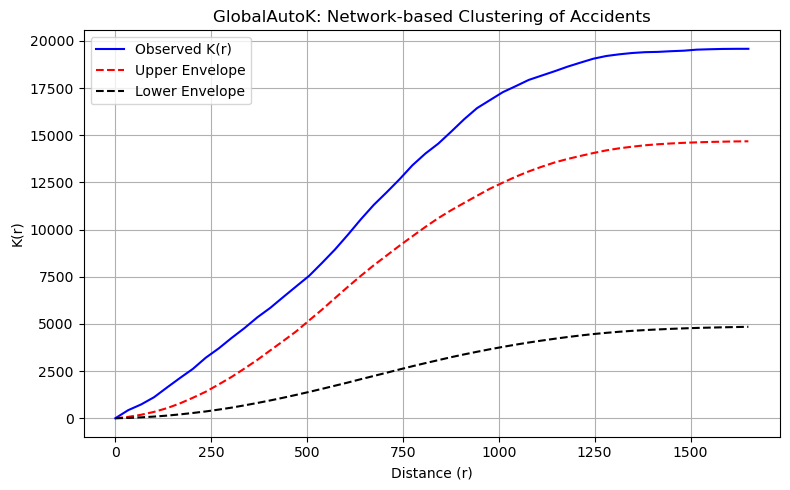

In [ ]:
# Computing the GlobalAutoK result using snapped points
kres = network.GlobalAutoK(
    network.pointpatterns["accidents"],
    nsteps=50,
    permutations=100
)

# Printing lambda (overall density) and distances
print(f"Density of points in the network (lambda): {kres.lam}")
print(f"Distances at which density is measured:\n{kres.xaxis}")

# Plotting observed vs envelopes
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(kres.xaxis, kres.observed, "b-", label="Observed K(r)")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper Envelope")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower Envelope")
ax.set_xlabel("Distance (r)")
ax.set_ylabel("K(r)")
ax.set_title("GlobalAutoK: Network-based Clustering of Accidents")
ax.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

We used GlobalAutoK to analyze clustering patterns in the snapped accident data along the Leeds city road network. The K-function evaluates how frequently accident points occur within different distances along the network compared to what would be expected under complete spatial randomness (CSR).

- The estimated density of accidents on the network is λ = 0.0216 accidents/meter, means there are relatively few accidents spread across the road network — typical in city-scale networks.

- The plot shows that the observed K(r) (blue) consistently exceeds the upper simulation envelope (red dashed line) across nearly all distances from 200m to 1500m.

- This clearly indicates statistically significant clustering of accidents on the network. 

The accidents are not randomly distributed, but instead tend to occur near each other, potentially near problematic intersections, busy road segments, or poorly designed infrastructure.


### Spatial Autocorrelation of Accidents (Moran’s I)

We compute **Moran’s I** to measure spatial autocorrelation of accident counts across road segments. Accident counts are assigned to each edge, and adjacency is defined using the network’s weights matrix. 

In [ ]:
# Getting the snapped point pattern
snapped_pointpatterns = network.pointpatterns['accidents']

# Counting the number of accidents per arc/road segment
counts = network.count_per_link(snapped_pointpatterns.obs_to_arc, graph=False)

# Accessing the network weights matrix
weights = network.w_network

# Getting edge identifiers in the weights matrix
edges = weights.neighbors.keys()

# Building list of values per edge in the same order as the weights
values = [
    counts[edge] if edge in counts else 0.0
    for edge in edges
]

# Computing Moran's I on the edge-based values
moran = esda.moran.Moran(values, weights)

# Printing results
print("Moran’s I:", round(moran.I, 4))
print("p-value:", round(moran.p_sim, 4))

Moran’s I: 0.1217
p-value: 0.003


A positive and significant Moran’s I value indicates that roads with many accidents tend to be near other accident-prone roads, revealing spatial clustering along connected segments.

- Moran’s I value was 0.1217, indicating a positive spatial autocorrelation.

- The p-value of 0.002 confirms this is statistically significant. (So we can reject the null hypothesis that accidents are randomly distributed.)

This means that road segments with a high number of accidents tend to be connected to other high-accident segments, forming spatial clusters of risk.

### Accident Proximity to Intersections

We calculate the distance from each snapped accident point to its nearest intersection (network node), and normalize these distances by the average road segment length. The resulting distribution shows whether accidents tend to occur near intersections or mid-segment.

/var/folders/lr/3kry83l1493bwdngkj2qg52m0000gn/T/ipykernel_58363/1905875061.py:16: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:32630

  distances = snapped_gdf.geometry.reset_index(drop=True).distance(nearest_geometries)


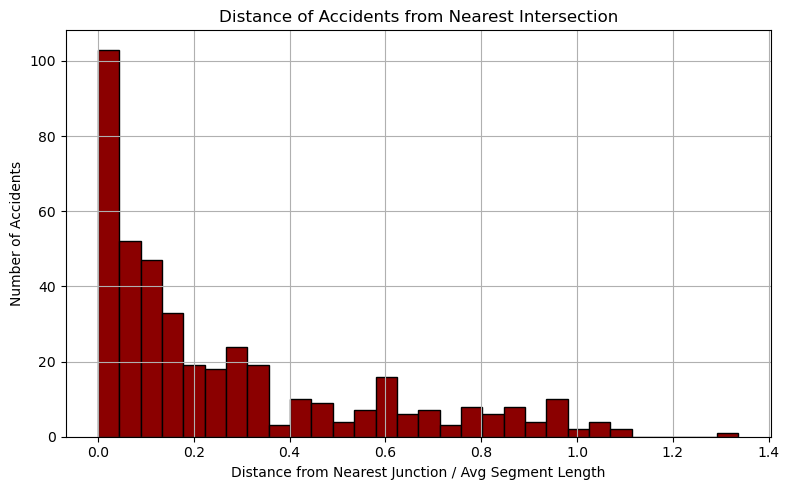

Mean normalized distance: 0.27
Max normalized distance: 1.34
Min normalized distance: 0.0


In [ ]:
# Get projected road network nodes (intersections)
nodes_proj = ox.graph_to_gdfs(road_graph_proj, nodes=True, edges=False)

# Getting snapped accident points from the network
snapped_gdf = sp.element_as_gdf(network, pp_name='accidents', snapped=True)

# Finding nearest intersection for each snapped accident
nearest_node_ids = snapped_gdf.geometry.apply(lambda pt: nodes_proj.distance(pt).idxmin())
nearest_geometries = nodes_proj.loc[nearest_node_ids].geometry.reset_index(drop=True)

# Computing distances from each accident to its nearest intersection
distances = snapped_gdf.geometry.reset_index(drop=True).distance(nearest_geometries)

# Normalizing distances by average road segment length
mean_edge_length = edges_proj['length'].mean()
normalized_distances = distances / mean_edge_length

# Plotting histogram of distances
plt.figure(figsize=(8, 5))
plt.hist(normalized_distances, bins=30, color='darkred', edgecolor='black')
plt.title("Distance of Accidents from Nearest Intersection")
plt.xlabel("Distance from Nearest Junction / Avg Segment Length")
plt.ylabel("Number of Accidents")
plt.grid(True)
plt.tight_layout()
plt.show()

# Printing Summary statistics
print("Mean normalized distance:", round(normalized_distances.mean(), 2))
print("Max normalized distance:", round(normalized_distances.max(), 2))
print("Min normalized distance:", round(normalized_distances.min(), 2))

“The majority of accidents occur near intersections, as the mean normalized distance was 0.27, and a substantial number of points were located within 20–30% of a segment’s length from an intersection.
 This suggests intersections are hotspots for accidents in the analyzed area of Leeds.”

# Task C: Voronoi Diagrams

# Task D: TransE, PROV, PageRank